# Identity
Deep Learning Final Exam | 2. Autoencoder\
Name: Michelle Nathania\
Student ID: 2702208575 (odd)

# Install necessary libraries
Install the required libraries for image processing, deep learning, and evaluation.


In [ ]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [ ]:
%pip install tensorflow scikit-image matplotlib numpy

# Import necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import zipfile
import random

import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.transform import resize
from skimage.metrics import structural_similarity as ssim

from sklearn.model_selection import train_test_split

from google.colab import drive

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Cropping2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner as kt

# Load dataset
The dataset is stored in my Google Drive, so we have to mount it first from Google Drive and import it to Google Colab.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


The zip path is on My Drive under the name 'B_23.zip'. The files will be extracted to a directory in Google Colab, tmp, with the name B_23_images.

Found 1074 images.

Sample image shapes:
(600, 600, 3)
(600, 600, 3)
(600, 600, 3)
(600, 600, 3)
(600, 600, 3)


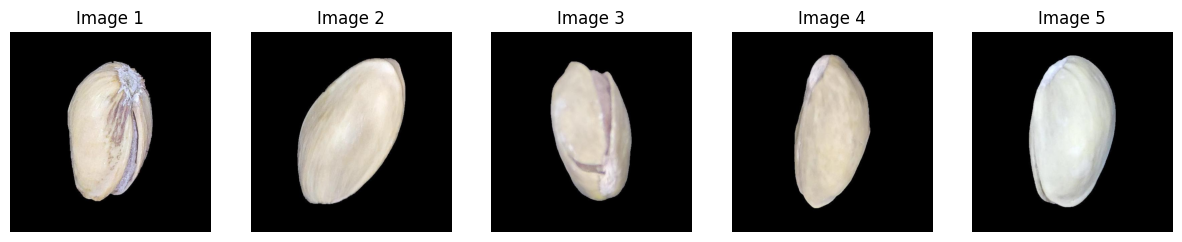

In [ ]:
zip_path = '/content/drive/MyDrive/B_23.zip'
extract_path = '/tmp/B_23_images'

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

image_files = []
for root, _, files in os.walk(extract_path):
    for f in files:
        if f.endswith('.jpg') or f.endswith('.png'):
            image_files.append(os.path.join(root, f))

print(f"Found {len(image_files)} images.")

sample_images = [imread(image_files[i]) for i in np.random.choice(len(image_files), min(5, len(image_files)), replace=False)]

print("\nSample image shapes:")
for img in sample_images:
    print(img.shape)

# Display sample images
fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
for i, img in enumerate(sample_images):
    axes[i].imshow(img)
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis('off')
plt.show()

# a, b. Exploratory Data Analysis (EDA)

Now that we have loaded the images, let's perform some Exploratory Data Analysis to understand the dataset. We will check several things:

- Number of images in the dataset
- Image dimensions (height, width, channels) and see if the images have the same size or not
- Display sample images to understand how the images look like

EDA is crucial because it helps to:
- Understand the structure and characteristics of the data
- Identify any potential issues or inconsistencies in the data, such as different size or corrupted data

We have 1074 images of pistachio. The image shapes (from the samples) are 600x600x3. So, the length x width is 600x600, and the 3 indicates the color channels as RGB (Red, Green, Blue). We will have to resize this to 100x100x3 to match the model input and output size, as stated on the case. This resizing process naturally involves a loss of some pixel-level detail, which can be observed as a slight blurriness in the resized images. However, the resizing is still acceptable because the 100x100 image still retains the essential features of the pistachio, such as the shape, color, and textures, which are the crucial informations that the autoencoder model should learn.

Preprocessing complete.
Clean images shape: (1074, 100, 100, 3)
Noisy images shape: (1074, 100, 100, 3)


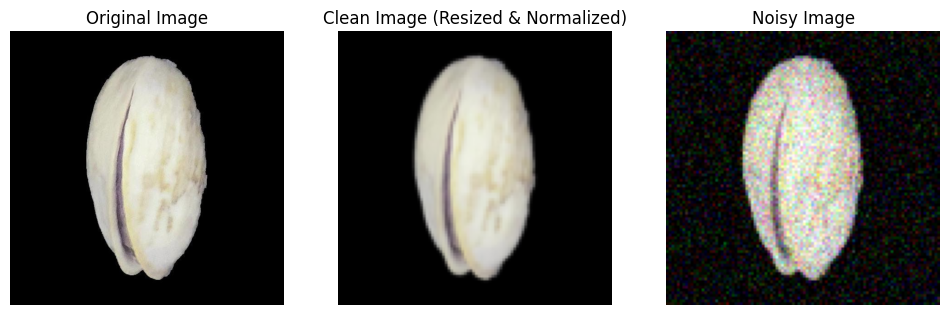

In [ ]:
target_size = (100, 100, 3)

clean_images = []
noisy_images = []

mean = 0.0
std_dev = 0.1

for img_path in image_files:
    try:
        img = imread(img_path)

        img_clean = resize(img, target_size, anti_aliasing=True)

        noise = np.random.normal(mean, std_dev, img_clean.shape)
        img_noisy = img_clean + noise

        img_noisy_clipped = np.clip(img_noisy, 0.0, 1.0)

        clean_images.append(img_clean)
        noisy_images.append(img_noisy_clipped)

    except Exception as e:
        print(f"Error processing image {img_path}: {e}")


clean_images = np.array(clean_images)
noisy_images = np.array(noisy_images)

print("Preprocessing complete.")
print(f"Clean images shape: {clean_images.shape}")
print(f"Noisy images shape: {noisy_images.shape}")

if len(clean_images) > 0:
    sample_index = random.randint(0, len(clean_images) - 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(imread(image_files[sample_index]))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(clean_images[sample_index])
    plt.title("Clean Image (Resized & Normalized)")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(noisy_images[sample_index])
    plt.title("Noisy Image")
    plt.axis('off')

    plt.show()

## Key Insights
- The images have been standardized, as all 1074 clean images have been resized to the required 100x100 px dimensions with 3 color channels. This is crucial to ensure compatibility with the model's input.
- The clean image is visibly blurrier than the original image. This is expected as we have downsized the resolution from 600x600x3 to 100x100x3. It demonstrates the information compression that occurs, but also shows that the essential features of the pistachio (shape, color) are still preserved, so the model can still learn from these images.
- The noisy image clearly illustrates the challenge presented for the autoencoder. By adding random Gaussian noise, we have created the input for the model. The autoencoder's goal will to take the Noisy Image and learn to reconstruct the Clean Image. Therefore, this is a denoising task.
- The data is ready for training as the preprocessing measures are done. Now, the data can be split for training, validation, and test sets.

# b. Train Test Split
The dataset will be split to 80/10/10 train/val/test. This ensures the model can learn as much as possible from the training, yet still having enough data for validation and testing to evaluate the model's performance.

First, the data will be split to 80% train and 20% temporary (which later will be val/test). This temp data is further split to 50% val and 50% test, so this results in 80/10/10 train/val/test ratio we aimed for.

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    noisy_images, clean_images, test_size=0.2, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((859, 100, 100, 3), (107, 100, 100, 3), (108, 100, 100, 3))

In [ ]:
y_train.shape, y_val.shape, y_test.shape

((859, 100, 100, 3), (107, 100, 100, 3), (108, 100, 100, 3))

# c. Model 1: Autoencoder
The first autoencoder model consists of a symmetrical encoder-decoder. The encoder progressively downsamples the 100x100x3 input image, using a series of Conv2D and MaxPooling2D layers to reduce the spatial dimensions to 25x25 while increasing the feature depth to 64. This process forces the network to learn a compressed, low-dimensional representation of the most important image features in a "bottleneck" layer.

The decoder then mirrors this process, taking the compressed representation and using UpSampling2D and Conv2D layers to progressively increase the spatial dimensions back to 100x100 while refining the feature maps. The final output layer is a Conv2D layer with 3 filters and a crucial sigmoid activation function, which ensures the output has the correct RGB channels and pixel values scaled between 0 and 1. To prepare for training, the model was compiled using the standard Adam optimizer and the mean_squared_error loss function, which effectively measures the pixel-wise difference between the reconstructed image and the clean target image.

In [ ]:
input_img = Input(shape=(100, 100, 3))

# encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# decoder
x = UpSampling2D((2, 2))(encoded)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,899 (331.64 KB)

 Trainable params: 84,899 (331.64 KB)

 Non-trainable params: 0 (0.00 B)

The model output shape has been adjusted to match the provided case.

---

We will use EarlyStopping to stop the epochs early if the val_loss is not improving for 5 consecutive epochs. This ensures the model has learned as much as possible, and not wasting time and resources for too many epochs.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    shuffle=True # shuffle the training data
)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 265ms/step - loss: 0.1191 - val_loss: 0.0126
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.0127 - val_loss: 0.0288
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0200 - val_loss: 0.0116
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0110 - val_loss: 0.0039
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0

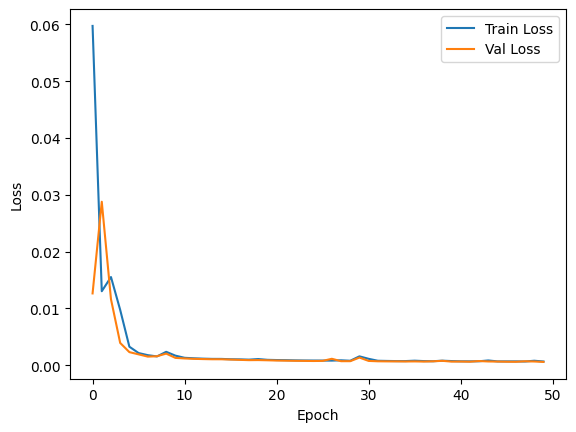

In [ ]:
# Plot the loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Insights
The training history of the model reveals a highly effective and stable learning process. As shown in the plot, the training loss (blue line) and validation loss (orange line) both decrease rapidly within the first 5-10 epochs, indicating that the model quickly learns the primary features required to denoise the images. After this initial phase, both loss curves converge and flatten out at a very low value (approximately 0.0005-0.0006), signifying that the model has reached its optimal performance without any signs of overfitting. The validation loss shows some minor volatility, spiking briefly after the first epoch before stabilizing. Tthis is a normal behavior in complex models and does not detract from the excellent final result, confirming the architecture's ability to generalize well to unseen data.

---

p.s.: I have saved the model and it is included on the .zip so we can skip the training process next time.

In [ ]:
autoencoder.save('autoencoder_model.keras')

# d. Model 2: Autoencoder Modified
To explore potential performance improvements, a second, deeper autoencoder architecture was developed. This model increases complexity by adding an additional layer to both the encoder and decoder. The encoder now consists of three Conv2D and MaxPooling2D blocks, which more aggressively downsample the input image. It progressively increases the feature depth from 32 to 64, and finally to 128 filters, while reducing the spatial dimensions from 100x100 down to a highly compressed 13x13 bottleneck. This deeper structure provides the model with greater capacity to learn more intricate and abstract features from the input images.

The decoder is designed to symmetrically mirror this deeper structure, using three blocks of UpSampling2D and Conv2D layers to reconstruct the image. A key architectural challenge arises from the odd-numbered 13x13 bottleneck, which, when upsampled, results in a 104x104 image instead of the original 100x100. To resolve this mismatch, a final Cropping2D layer is strategically added to trim the output back to the correct 100x100 dimensions, ensuring compatibility with the target data. As with the baseline model, it is compiled using the Adam optimizer and mean_squared_error loss function, with a final sigmoid activation to scale the output pixels between 0 and 1.

In [ ]:
input_img = Input(shape=(100, 100, 3))

# encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# decoder
x = UpSampling2D((2, 2))(encoded)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# added because the previous layer will result in 104x104x3
decoded = Cropping2D(cropping=((2, 2), (2, 2)))(x)

autoencoder_mod = Model(input_img, decoded)
autoencoder_mod.compile(optimizer='adam', loss='mean_squared_error')
print("--- Deeper Autoencoder Model Summary ---")
autoencoder_mod.summary()

--- Deeper Autoencoder Model Summary ---


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_14 (UpSampling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 26, 26, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_15 (UpSampling2D) │ (None, 52, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 52, 52, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_16 (UpSampling2D) │ (None, 104, 104, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 104, 104, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 104, 104, 3)    │           867 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d_2 (Cropping2D)       │ (None, 100, 100, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history2 = autoencoder_mod.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    shuffle=True
)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - loss: 0.1002 - val_loss: 0.0038
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.

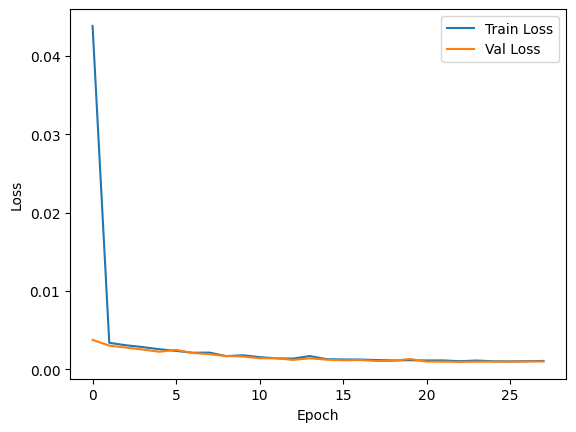

In [ ]:
# Plot the loss
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Insights
The training history of the modified, deeper autoencoder demonstrates an exceptionally stable and efficient learning process. The plot shows both the training and validation loss decreasing rapidly and smoothly from the start, converging at an extremely low loss value in under 20 epochs. A key insight from this plot is that the validation loss consistently remains below the training loss throughout the entire process. This indicates that the model generalizes well to unseen data, showing no signs of overfitting. The EarlyStopping callback halted the training once the model reached its peak performance, making the process both effective and computationally efficient.

---

p.s.: I have saved the model and it is included on the .zip so we can skip the training process next time.

In [ ]:
autoencoder_mod.save('autoencoder_model_mod.keras')

# d. Model 3: Tuned Autoencoder
To maximize our model's performance, we implemented a hyperparameter tuning process using the KerasTuner library. While both models performance were exceptionally good, but since the baseline model demonstrated a slightly lower and more stable validation loss compared to the more complex version, we focused our tuning efforts on this architecture to find its optimal configuration.

We defined a search space for three crucial hyperparameters: the number of filters in the first two convolutional layers (hp_filters_1 and hp_filters_2) and the Adam optimizer's learning rate. After running the search, KerasTuner identified the following optimal configuration:

Optimal Filters (Layer 1): 48

Optimal Filters (Layer 2): 96

Optimal Learning Rate: 0.001

The final model used for evaluation was then constructed using these best-performing parameters.

In [ ]:
def build_tuned_model(hp):
    input_img = Input(shape=(100, 100, 3))

    hp_filters_1 = hp.Int('filters_1', min_value=16, max_value=48, step=16)
    hp_filters_2 = hp.Int('filters_2', min_value=32, max_value=96, step=32)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # encoder
    x = Conv2D(hp_filters_1, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(hp_filters_2, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(hp_filters_2, (3, 3), activation='relu', padding='same')(x)

    # decoder
    x = UpSampling2D((2, 2))(encoded)
    x = Conv2D(hp_filters_1, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(hp_filters_1, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder_tuned = Model(input_img, decoded)
    autoencoder_tuned.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='mean_squared_error'
    )
    return autoencoder_tuned

In [ ]:
tuner = kt.RandomSearch(
    build_tuned_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='autoencoder_tuning_dir',
    project_name='denoising_project'
)

In [ ]:
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

Trial 5 Complete [00h 01m 01s]
val_loss: 0.0005568563938140869

Best val_loss So Far: 0.00035579947871156037
Total elapsed time: 00h 06m 07s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
print(f"""
--- Best Hyperparameters Found ---
Filters in Layer 1: {best_hps.get('filters_1')}
Filters in Layer 2: {best_hps.get('filters_2')}
Learning Rate: {best_hps.get('learning_rate')}
""")


--- Best Hyperparameters Found ---
Filters in Layer 1: 48
Filters in Layer 2: 96
Learning Rate: 0.001



In [ ]:
autoencoder_tuned = tuner.hypermodel.build(best_hps)
autoencoder_tuned.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 100, 100, 48)   │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 50, 50, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 50, 50, 96)     │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 25, 25, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 25, 25, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 50, 50, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 50, 50, 48)     │        41,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 100, 100, 48)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 100, 100, 48)   │        20,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 100, 100, 3)    │         1,299 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,555 (740.45 KB)

 Trainable params: 189,555 (740.45 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history3 = autoencoder_tuned.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    shuffle=True
)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step - loss: 0.1175 - val_loss: 0.0131
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0120 - val_loss: 0.0046
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0011 - val_loss: 9.2009e-04
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss

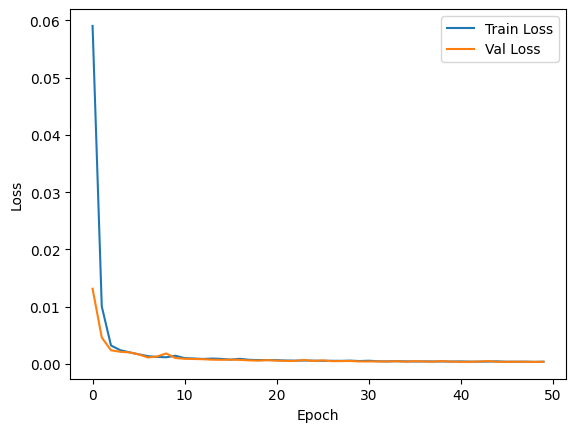

In [ ]:
# Plot the loss
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Insights
The training history of the tuned model showcases a highly efficient and robust learning process. The plot reveals an extremely rapid convergence, where both the training and validation loss drop to a near-optimal, low value within the first 5 epochs. A significant insight is that the validation loss consistently stays below the training loss, which indicates that the model generalizes well to unseen data. This behavior confirms the success of the hyperparameter tuning, resulting in a model that learns the essential features of the data quickly and effectively without any signs of overfitting.

---

p.s.: I have saved the model and it is included on the .zip so we can skip the training process next time.

In [ ]:
autoencoder_tuned.save('autoencoder_model_tuned.keras')

# e. Evaluation
To evaluate the performance of the three models: the baseline, modified, and tuned autoencoders, we performed a comparative analysis using the Structural Similarity Index (SSIM). This metric is superior to simple pixel-wise error as it measures the perceptual similarity between two images, considering factors like luminance, contrast, and structure. The evaluation was conducted on the unseen test set, where the denoised images produced by each model were compared against the original clean images. The average SSIM score was calculated for each model, and the results were compiled into a final comparison table to quantitatively determine which architecture was most effective at reconstructing the high-fidelity structure of the original images after removing the noise.

In [ ]:
denoised_images_base = autoencoder.predict(X_test)
denoised_images_mod = autoencoder_mod.predict(X_test)
denoised_images_tuned = autoencoder_tuned.predict(X_test)

predictions = {
    'Autoencoder (Base)': denoised_images_base,
    'Autoencoder (Modified)': denoised_images_mod,
    'Autoencoder (Tuned)': denoised_images_tuned
}

results_list = []

for model_name, denoised_images in predictions.items():
    ssim_scores = []
    for i in range(len(y_test)):
        score = ssim(y_test[i], np.clip(denoised_images[i], 0, 1), channel_axis=-1, data_range=1.0)
        ssim_scores.append(score)

    average_ssim = np.mean(ssim_scores)

    results_list.append({
        'Model': model_name,
        'Average SSIM': average_ssim
    })

results_df = pd.DataFrame(results_list)
results_df = results_df.set_index('Model')

print("\n--- Model Performance Comparison (SSIM) ---")
results_df

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

--- Model Performance Comparison (SSIM) ---


,Average SSIM
Model,
Autoencoder (Base),0.958711
Autoencoder (Modified),0.939547
Autoencoder (Tuned),0.967766


## Insights

**Baseline Autoencoder**\
The baseline autoencoder achieved an excellent average SSIM score of approximately 0.9587. This result is very strong and serves as a great starting point. An SSIM score this close to 1.0 indicates that the model is already highly effective at reconstructing the original image's structure from the noisy input. It proves that the initial, simple architecture was well-suited for this problem and successfully learned the key features of the pistachio images.

**Modified Autoencoder**\
The modified, deeper autoencoder achieved an average SSIM score of about 0.9395, which is slightly lower than the baseline model. This is a crucial insight: simply increasing a model's complexity by adding more layers does not guarantee better performance. In this case, the added depth may have made the model more difficult to train effectively or potentially led it to learn less useful, overly abstract features. This result highlights that a simpler, more direct architecture can sometimes be superior.

**Tuned Autoencoder**\
The tuned autoencoder is the clear winner, achieving the highest average SSIM score of approximately 0.9677. This score, being the closest to 1.0, demonstrates that this model produces the most accurate reconstructions of the clean images. The reason for its superior performance is the hyperparameter tuning process, which tested different combinations of filters and learning rates to find the optimal configuration for this specific dataset and task, leading to a measurable improvement over the already strong baseline.

---

The code block below is to visualize the original image, noised image (for the model's input), and the denoised image from the model to see the comparison.

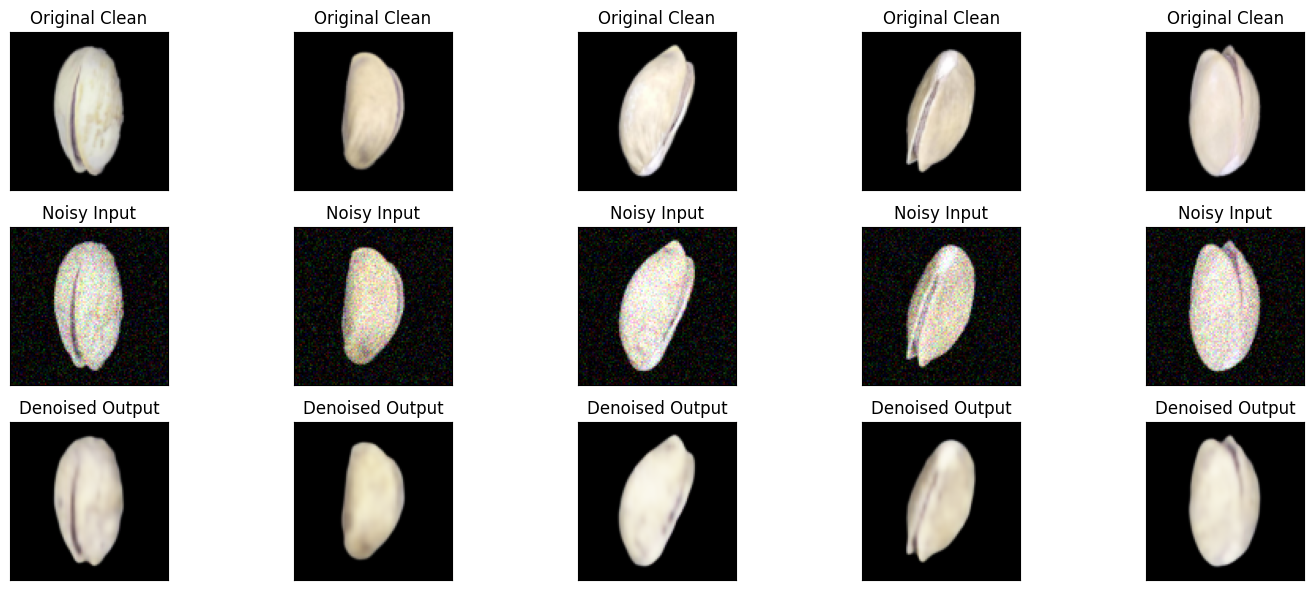

In [ ]:
best_model_predictions = denoised_images_tuned
n_images = 5
plt.figure(figsize=(15, 6))
for i in range(n_images):
    ax = plt.subplot(3, n_images, i + 1)
    plt.imshow(y_test[i])
    plt.title("Original Clean")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n_images, i + 1 + n_images)
    plt.imshow(X_test[i])
    plt.title("Noisy Input")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n_images, i + 1 + 2*n_images)
    plt.imshow(np.clip(best_model_predictions[i], 0, 1))
    plt.title("Denoised Output")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

We can see that the denoised outputs are very similar to the original clean data, which supports the reason why the SSIM scores are good.

# f. Video Explanation
Video is accessible [here](https://youtu.be/cz7wRcidbFg)\
Powerpoint is accessible [here](https://www.figma.com/deck/yZATHcO1pfzO4fWcb3yHiU/DL-PPT?node-id=40-431&t=V5DUkv2wCp47KQ6H-1)